In [1]:
import os
import numpy as np
import nibabel as nib
import torchio.data
from tqdm import tqdm
from torch.utils.data import Dataset
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import Normalize, ImagePair, calculate_overlap, data_split, RealImage, real_data
import torchvision
from models.generator import GeneratorRRDB
from models.generator_marcel import DeepUResnet
from models.discriminator import Discriminator
from models.feature_extractor import FeatureExtractor

from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
import pytorch_lightning as pl

from torchvision.utils import save_image
from torchsummary import summary
import time
from utils import save_subject
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import normalized_root_mse as NRSME
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from RandomRotate import RandomRotate
from contextlib import contextmanager

import psutil  # installed it with pip
import cv2
import visualization
plot_volume = visualization.plot_volume_interactive

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
std = 0.3548
patients_frac = .5
root_dir = '/mnt/beta/djboonstoppel/Code'
data_resolution = '2mm_1mm'
patch_size = 64
patch_overlap = .5
batch_size = 16
num_workers = 4

In [6]:
data_path = os.path.join(root_dir, 'data')
val_subjects = data_split('validation', patients_frac=patients_frac, root_dir=data_path, data_resolution=data_resolution, numslices=None)
print(len(val_subjects))

Loading validation set...
15


In [7]:
print(val_subjects[0]['LR'][tio.DATA].shape)

torch.Size([1, 224, 224, 67])


In [20]:
plot_volume(val_subjects[3]['HR_msk_bin'][tio.DATA].squeeze().numpy())




Output()

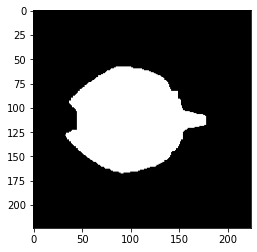

In [99]:
mask = val_subjects[0]['HR_msk_bin'][tio.DATA]
# mask_binary = val_subjects[1]['HR_msk'][tio.DATA][val_subjects[1]['HR_msk'][tio.DATA]>1]=1
plt.imshow(mask[0,:,:,25], cmap='gray')

In [ ]:
mask[mask>0]=1
plt.imshow(mask[0,:,:,25], cmap='gray')

Time: 0.0885179043 s
(224, 224, 69)


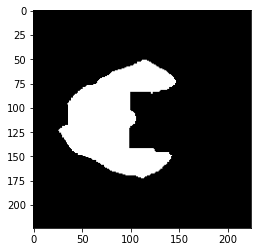

In [108]:
mask = nib.load('data/brain_simulated_t1w_mri/2mm_1mm/HR_msk/23-Aug-2021_Ernst_labels_100206_3T_T1w_MPR1_img_act_1_contrast_1_Res_1_1_2_msk.nii.gz')
mask = mask.get_fdata()
kernel = np.ones((10,10,10,10,10), np.uint8)

start_time = time.time()
mask[mask>0]=1
mask = cv2.erode(mask, np.ones((10,10)), iterations=2)

end_time = time.time()
print('Time: {:.10f} s'.format(end_time - start_time))
print(mask.shape)
plt.imshow(mask[:,:,20], cmap='gray')

In [ ]:
transform = tio.Compose([
    Normalize(std=std),
    # tio.RandomNoise(p=0.5),
    # tio.RandomFlip(axes=(0, 1), flip_probability=1),
    # tio.RandomFlip(axes=(0, 1), flip_probability=0.9),
])

In [8]:
val_set = tio.SubjectsDataset(val_subjects, transform=None)

overlap, nr_patches = calculate_overlap(val_subjects[0]['LR'],
                                        (patch_size, patch_size),
                                        (patch_overlap, patch_overlap)
                                        )
samples_per_volume = nr_patches

sampler = tio.data.GridSampler(patch_size=(patch_size, patch_size, 1),
                               patch_overlap=overlap,
                                    # padding_mode=0,
                                    )
# probabilities = {0: 0,
#                  1: 1,
#                  2: 1,
#                  3: 1,
#                  4: 1,
#                  5: 1,
#                  6: 1,
#                  7: 1,
#                  8: 1,
#                  9: 1,
#                  10: 1,
#                  11: 1,
#                  12: 1,
#                  13: 1,
#                  14: 1,
#                  15: 1,
#                  16: 1,
#                  }
# sampler = tio.data.LabelSampler(
#     patch_size=(patch_size, patch_size, 1),
#     label_name='HR_msk',
#     label_probabilities=probabilities,
# )
# generator = sampler(subject)
# for patch in generator:
#     print(patch.shape)
# If you want a specific number of patches from a volume, e.g. 10:

# generator = sampler(subject, num_patches=10)
# for patch in iterator:
#     print(patch.shape)


val_queue = tio.Queue(
    subjects_dataset=val_set,
    max_length=samples_per_volume * 10,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)
val_loader = torch.utils.data.DataLoader(
    val_queue,
    batch_size=batch_size,
    num_workers=0,
    )
train_len = len(val_loader)

In [11]:
batch = next(iter(val_loader))


In [13]:
print(batch['LR'][tio.DATA].shape)

torch.Size([16, 1, 64, 64, 1])


In [3]:
print(tio.__version__)

0.18.76


In [9]:
aggregator = tio.data.GridAggregator(sampler)#, overlap_mode='average')

# for patches_batch in val_loader:
#     imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA], patches_batch['HR'][tio.DATA]
#     locations = patches_batch[tio.LOCATION]
#     aggregator.add_batch(imgs_hr, locations)

AttributeError: 'NoneType' object has no attribute 'spatial_shape'

In [17]:
test_dic = {
    'NCC': {
        # 'SR0': [],
        # 'SR1': [],
        # 'SR2': [],
    },
    'SSIM': {
        # 'SR0': [],
        # 'SR1': [],
        # 'SR2': [],
    },
    'NRMSE': {
        # 'SR0': [],
        # 'SR1': [],
        # 'SR2': [],
    },
}
# test_dic = {'SSIM', 'NRMSE', 'NCC'}
num = 3
z = ['SSIM', 'NRMSE', 'NCC']
x = ['SR0', 'SR1', 'SR2']
y0 = [1, 2, 3]
y1 = [4, 5, 6]
y2 = [7, 8, 9]
for i in range(num):

    for key in x:
        test_dic['SSIM'][key], test_dic['NRMSE'][key], test_dic['NCC'][key] = y0

    # test_dic['SSIM']['SR0'] = test1
    # test_dic['SSIM']['SR1'] = test4
    # test_dic['SSIM']['SR2'] = test7

print(test_dic)

{'NCC': {'SR0': 3, 'SR1': 3, 'SR2': 3}, 'SSIM': {'SR0': 1, 'SR1': 1, 'SR2': 1}, 'NRMSE': {'SR0': 2, 'SR1': 2, 'SR2': 2}}
